In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import shap


## Primera Actividad: Minería de Datos

He escogido un dataset con datos de reservas y cancelaciones de un hotel. Nuestra target será binaria (0 o 1), y será si la reserva va a ser cancelada o no. La idea final será elaborar un modelo que prediga con pocos fallos una cancelación. De esta manera, sabremos a la hora de una reserva si va a ser cancelada en un futuro, y podemos jugar con el overbooking de las habitaciones, volviéndolas a poner a la venta. Esto puede ser especialmente útil en semanas de temporada alta o con eventos especiales.

A lo largo del trabajo vamos a ponernos en la piel de un hotel cercano a la playa.

Leemos el dataset (obtenido de Kaggle: https://www.kaggle.com/datasets/arezaei81/hotel-bookingcvs)

In [4]:
data = pd.read_csv("hotel_booking.csv")

#### Descripción de las columnas del dataset

| Column Name                     | Data Type | Description                                                                                      |
|---------------------------------|-----------|--------------------------------------------------------------------------------------------------|
| hotel                           | object    | Nombre del hotel donde se hizo la reserva (por ejemplo, "City Hotel" o "Resort Hotel").          |
| is_canceled                     | int64     | Indicador de cancelación: 1 si la reserva fue cancelada, 0 si no lo fue.                         |
| lead_time                       | int64     | Número de días entre la fecha de reserva y la fecha de llegada.                                  |
| arrival_date_year               | int64     | Año de llegada de la reserva.                                                                    |
| arrival_date_month              | object    | Mes de llegada de la reserva (como texto, por ejemplo, "January", "February").                   |
| arrival_date_week_number        | int64     | Número de la semana del año en la que ocurre la llegada.                                         |
| arrival_date_day_of_month       | int64     | Día del mes en que ocurre la llegada.                                                            |
| stays_in_weekend_nights         | int64     | Número de noches de estadía durante el fin de semana (viernes y sábado).                         |
| stays_in_week_nights            | int64     | Número de noches de estadía durante la semana (lunes a jueves).                                  |
| adults                          | int64     | Número de adultos incluidos en la reserva.                                                      |
| children                        | float64   | Número de niños incluidos en la reserva.                                                        |
| babies                          | int64     | Número de bebés incluidos en la reserva.                                                        |
| meal                            | object    | Tipo de comida reservada: opciones como BB (Bed & Breakfast), HB (Half Board), FB (Full Board).  |
| country                         | object    | Código del país de origen del cliente (por ejemplo, "PRT" para Portugal).                        |
| market_segment                  | object    | Segmento de mercado: cómo se hizo la reserva (por ejemplo, "Direct", "Online TA").               |
| distribution_channel            | object    | Canal de distribución: cómo se distribuyó la reserva (por ejemplo, "Corporate", "Travel Agent"). |
| is_repeated_guest               | int64     | Indicador de si el cliente es un huésped repetido (1 para sí, 0 para no).                        |
| previous_cancellations          | int64     | Número de reservas previas canceladas por el cliente.                                            |
| previous_bookings_not_canceled  | int64     | Número de reservas previas no canceladas por el cliente.                                         |
| reserved_room_type              | object    | Tipo de habitación reservada (por ejemplo, A, B, C).                                             |
| assigned_room_type              | object    | Tipo de habitación asignada finalmente (puede diferir de la reservada).                          |
| booking_changes                 | int64     | Número de cambios realizados en la reserva por el cliente.                                       |
| deposit_type                    | object    | Tipo de depósito realizado: "No Deposit", "Refundable", "Non Refundable".                        |
| agent                           | float64   | Código del agente que gestionó la reserva (si aplica).                                           |
| company                         | float64   | Código de la compañía asociada a la reserva (si aplica).                                         |
| days_in_waiting_list            | int64     | Número de días que la reserva estuvo en lista de espera.                                         |
| customer_type                   | object    | Tipo de cliente: "Transient", "Contract", "Group", etc.                                          |
| adr                             | float64   | Tasa diaria promedio (Average Daily Rate), es decir, ingreso promedio por habitación ocupada.    |
| required_car_parking_spaces     | int64     | Número de espacios de estacionamiento requeridos por el cliente.                                 |
| total_of_special_requests       | int64     | Número de solicitudes especiales hechas por el cliente (por ejemplo, cama extra).                |
| reservation_status              | object    | Estado de la reserva: "Canceled", "Check-Out", "No-Show".                                        |
| reservation_status_date         | object    | Fecha en que se actualizó el estado de la reserva.                                               |
| name                            | object    | Nombre del cliente (puede estar anonimizado).                                                    |
| email                           | object    | Correo electrónico del cliente (puede estar anonimizado).                                        |
| phone-number                    | object    | Número de teléfono del cliente (puede estar anonimizado).                                        |
| credit_card                     | object    | Número de tarjeta de crédito del cliente (puede estar anonimizado).                              |


1º - Tamaño de los datos. Tenemos 119390 registros en nuestro dataset

In [5]:
len(data) 

119390

2º - Comprobamos duplicados: No tenemos filas duplicadas en nuestro dataset

In [6]:
duplicados = data.duplicated()
print(data[duplicados])

Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, company, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date, name, email, phone-number, credit_card]
Index: []

[0 rows x 36 columns]


3º - Especificar variables de cada tipo. Vamos a ver los tipos que vienen por defecto, y después transformamos las que no estén correctas (Discretización de variables)

In [7]:
print(data.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

Fijándonos en la descripción del dataset, tenemos algunas variables numéricas que no deberían ser tartadas como tal, ya que representan realmente categorías. Transformamos todas las que deben ser categóricas a tipo str por si acaso:

In [8]:
# Fijándonos en la descripción de las columnas del dataset tenemos:
categorical_columns = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

# Vamos a convertir estas columnas a tipo str, ya que deberán ser tratados como categorías aunque almacenen valores numéricos
for column in categorical_columns:
    if column in data.columns:
        data[column] = data[column].astype(str)

4º - Valores fuera de rango

In [9]:
# Calcular el mínimo y máximo para cada columna
minimos = data.min()
maximos = data.max()

# Combinar en un DataFrame para una vista más clara
rangos = pd.DataFrame({'Mínimo': minimos, 'Máximo': maximos})

display(rangos)

,Mínimo,Máximo
hotel,City Hotel,Resort Hotel
is_canceled,0,1
lead_time,0,737
arrival_date_year,2015,2017
arrival_date_month,April,September
arrival_date_week_number,1,9
arrival_date_day_of_month,1,9
stays_in_weekend_nights,0,19
stays_in_week_nights,0,50
adults,0,55


Hay varias columnas que pueden tener datos fuera de rango.
- En primer lugar, el máximo del nº de adultos es 55, esto parece demasiado para una reserva de un hotel. Es posible que sea una reserva por un evento, una organización o algo del estilo. Sin embargo, sigue siendo un valor muy anómalo.
- En segundo lugar, tenemos que el mínimo de "ADR" es un número negativo, cosa que realmente no tiene mucho sentido ya que el ADR es le beneficio medio de una habitación por noche diaria. Al ser negativo, nos está inidicando que con alguna reserva estamos perdiendo dinero. Faltaría más contexto, pero es cosa que realmente no tiene mucho sentido.
- Después tenemos previous cancellations, previous reservations o booking changes que llegan a valores relativamente altos. Es posible que haya individuos que repitan muchas veces y se den estas casuísticas. Son outliers pero no parecen incorrectos.

5º - Tratamos datos con valores fuera de rango

- Adults: Podemos ver que tenemos únicamente 12 reservas que tienen más de 10 adultos, y además, todas ellas han sido canceladas. Esto realmente es un poco extraño y nos hace pensar que nuestra primera hipótesis sobre que eran reservas para eventos es incorrecta, o quizás las toma como canceladas pero simplemente ha habido una cancelación de última hora en alguna de las habitaciones. Por ello, vamos a eliminar estos registros directamente. Ya que, como el objetivo del trabajo es controlar el overbooking y las cancelaciones, al tener tan pocos datos sobre reservas de muchos individuos, nos es difícil trabajar. Pienso que, para estas reservas de eventos que podrían catalogarse como especiales, podríamos elaborar otro modelo para tratar de predecir el número de personas que se bajarán de la reserva y el número de habitaciones que se quedarán libres, ya que, me resulta muy extraño que un grupo de personas reserve tantas habitaciones y las cancele todas.

In [10]:
# Filtrar filas donde 'adults' es mayor a 30
data_adults_mayor_10 = data[data['adults'] > 10]

# Contar las filas
conteo = len(data_adults_mayor_10)

print(f"Número de filas donde 'adults' es mayor a 10: {conteo}")

registros_is_canceled = data_adults_mayor_10[['is_canceled']]

print(registros_is_canceled)

Número de filas donde 'adults' es mayor a 10: 12
     is_canceled
1539           1
1587           1
1643           1
1752           1
1884           1
1917           1
1962           1
2003           1
2164           1
2173           1
2228           1
2418           1


In [11]:
data = data.drop(data[data['adults'] > 10].index)

- ADR: Contamos únicamente con un registro que tiene valores negativos. Es posible que se deba a algún fallo del sistema y hayamos perdido dinero con la reserva. En cualquier caso, vamos a eliminar esta fila. Además, si nos fijamos en el top 5 de los valores de ADR más altos, tenemos que hay un registro que se va demasiado del resto, con 5400$. Vamos a eliminarlo también, ya que debe haber sido un error del sistema.

In [12]:
# Filtrar filas donde 'adr' es menor a 0
data_ADR_negativo = data[data['adr'] < 0]

# Contar las filas
conteo = len(data_ADR_negativo)

print(f"Número de filas donde 'adults' es mayor a 10: {conteo}")

registros_is_canceled = data_ADR_negativo[['is_canceled']]

print(registros_is_canceled)

Número de filas donde 'adults' es mayor a 10: 1
      is_canceled
14969           0


In [13]:
# Obtener los 10 valores más altos de la columna 'adr'
top_adr = data['adr'].sort_values(ascending=False).head(5)

# Mostrar los 10 valores más altos
print("Top 5 valores más altos de 'adr':")
print(top_adr)

Top 5 valores más altos de 'adr':
48515     5400.0
111403     510.0
15083      508.0
103912     451.5
13142      450.0
Name: adr, dtype: float64


In [14]:
data = data.drop(data[data['adr'] < 0].index)

In [15]:
data = data[data['adr'] != data['adr'].max()]

- El resto de valores que parecen estar fuera de rango vamos a dejarlos de momento. Parecen clientes habituales simplemente, que han cancelado y reservado muchas veces.

6º- Valores faltantes (nulos): En todo nuestro dataset tenemos únicamente 4 valores nulos. Están en la columna de children

In [16]:
null_counts = data.isnull().sum()  # Contar los valores nulos en cada columna
null_columns = null_counts[null_counts > 0]  # Filtrar columnas con valores nulos
print(null_columns)

children    4
dtype: int64


In [17]:
# Filtrar las filas con valores nulos en la columna 'children'
data_with_null_children = data[data['children'].isnull()]

# Mostrar el nuevo dataframe
display(data_with_null_children)

unique_values = data['children'].unique()
print(unique_values)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
40600,City Hotel,1,2,2015,August,32,3,1,0,2,...,Transient-Party,12.0,0,1,Canceled,2015-08-01,Craig Campos,CraigCampos@mail.com,820-622-9854,************7219
40667,City Hotel,1,1,2015,August,32,5,0,2,2,...,Transient-Party,12.0,0,1,Canceled,2015-08-04,David Murphy,David.Murphy94@yahoo.com,231-438-6733,************8925
40679,City Hotel,1,1,2015,August,32,5,0,2,3,...,Transient-Party,18.0,0,2,Canceled,2015-08-04,Frank Burton,Frank.Burton@comcast.net,395-084-3601,************6190
41160,City Hotel,1,8,2015,August,33,13,2,5,2,...,Transient-Party,76.5,0,1,Canceled,2015-08-09,Jerry Roberts,JRoberts@hotmail.com,979-355-3554,************5648


[ 0.  1.  2. 10.  3. nan]


7º - Tratamiento de valores faltantes (nulos): Podemos interpretar que al tener valores nulos en la variable children, simplemente es que no ha habido ningún niño en la reserva, por lo que vamos a tomar 0 en lugar de nulo.

In [18]:
data['children'] = data['children'].fillna(0)
print(data['children'].isnull().sum()) # Comprobación. Debe imprimir 0

0


8º - Creamos nuevas variables que pueden ser interesantes

- En primer lugar, vamos a tomar el número de reservas que ha realizado una persona. Para ello, vamos a tomar el número de veces que se repiten los correos

In [19]:
# Calcular el número de reservas por correo electrónico
email_counts = data['email'].value_counts()
# Crear un DataFrame con los conteos
email_counts_df = email_counts.reset_index()
email_counts_df.columns = ['email', 'n_reservations']
# Unir los conteos al DataFrame original
data = data.merge(email_counts_df, on='email', how='left')

- En segundo lugar, vamos a crear una columna binaria para analizar si las habitaciones asignadas coinciden con las reservadas. Si no coinciden, pondremos un 1, y si coinciden un 0. La idea es que es posible que a la hora de la asignación pudo haber un error en la reserva, y este puede ser un motivo posible de cancelación

In [20]:
# Crear la nueva columna 'different_room_reserved_assigned'
data['different_room_reserved_assigned'] = (data['reserved_room_type'] != data['assigned_room_type']).astype(int)

9º - Identificar la target y verificar el balace entre clases: Vemos la cantidad de canceladas y no canceladas que tenemos. Hay un pequeño desbalance en la proporción de 1 y 0 que tenemos, tenemos más no canceladas. Sin embargo, esta diferencia no es muy grande, no parece nada preocupante.

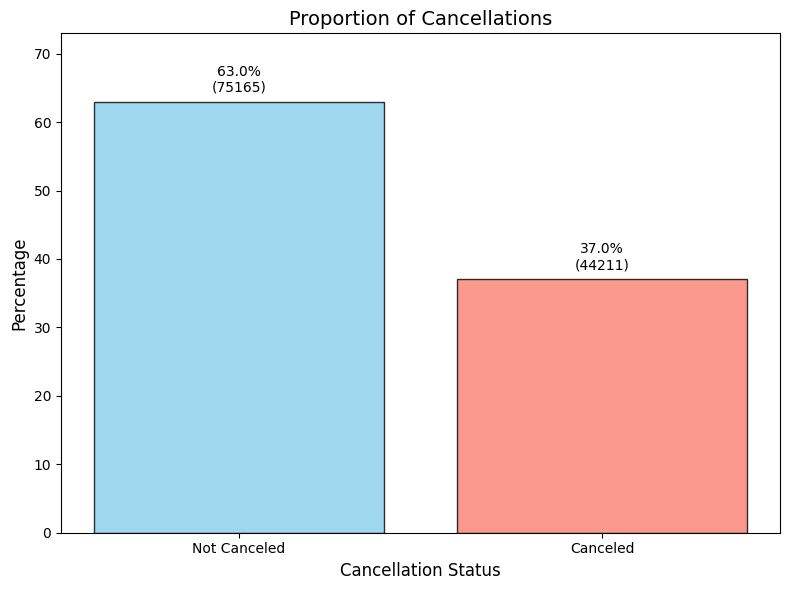

In [21]:
# Calcular la proporción y el conteo total de cada categoría
cancel_counts = data['is_canceled'].value_counts()
cancel_percentages = (cancel_counts / len(data)) * 100
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(cancel_counts.index, cancel_percentages, color=['skyblue', 'salmon'], alpha=0.8, edgecolor='black')
# Añadir etiquetas a las barras
for bar, count, percentage in zip(bars, cancel_counts, cancel_percentages):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Posición x (centro de la barra)
        bar.get_height() + 1,  # Posición y (ligeramente encima de la barra)
        f'{percentage:.1f}%\n({count})',  # Texto de la etiqueta
        ha='center', va='bottom', fontsize=10, color='black'
    )
# Configurar el gráfico
ax.set_title('Proportion of Cancellations', fontsize=14)
ax.set_xlabel('Cancellation Status', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Canceled', 'Canceled'], fontsize=10)
ax.set_ylim(0, max(cancel_percentages) + 10)  # Añadir espacio para las etiquetas
# Mostrar el gráfico
plt.tight_layout()
plt.show()

10º - Analizar la correlación entre las variables: Las variables son muy independientes unas de otras, no tenemos argumentos para eliminar una porque es dependiente de otra.

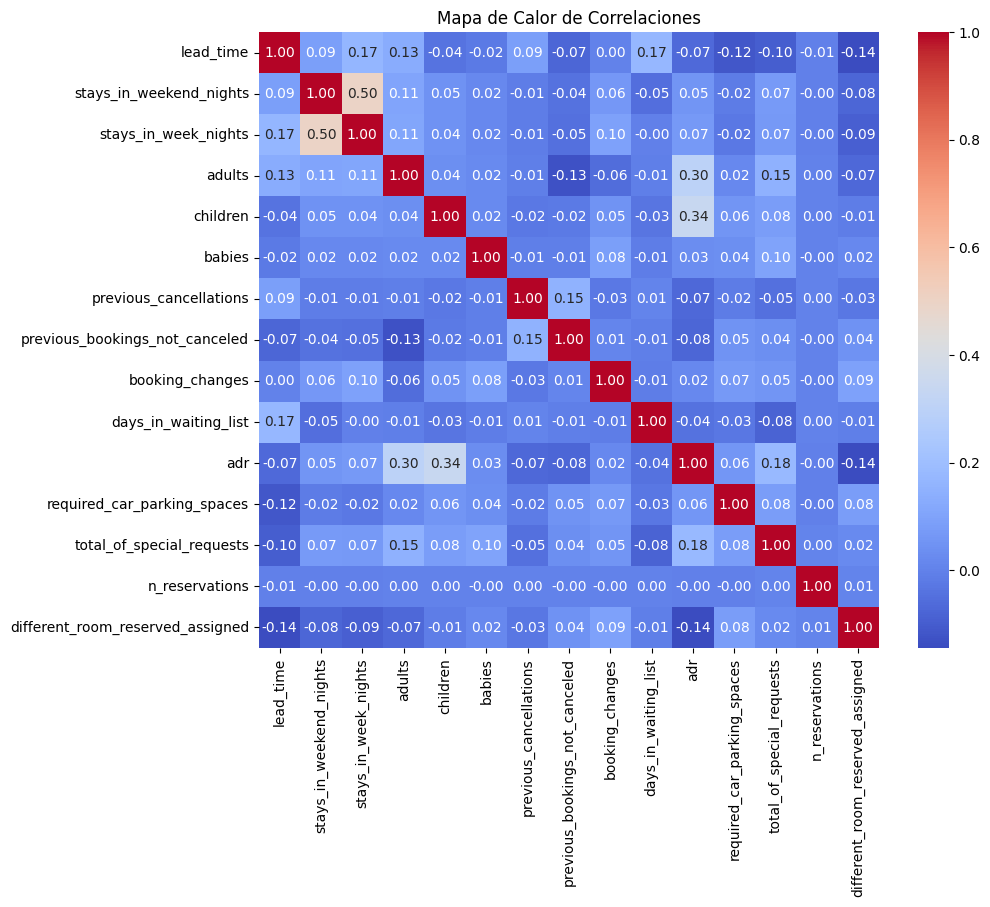

In [22]:
# Seleccionar solo las columnas numéricas
numeric_data = data.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Calor de Correlaciones")
plt.show()

11º - Calcular estadísticas de variables numéricas: Podemos ver alguna cosa interesante. Por ejemplo:
- El promedio de estancia en nuestro hotel es de 2.5 noches.
- La media de ADR (beneficio por habitación) es de 101$.
- Si nos fijamos en los percentiles, prácticamente nadie requiere plazas de parking. Podría ser interesante, si estamos cerca de la playa y tenemos suficientes plazas, poner a funcionar nuestro parking no solo para clientes del hotel, sino para todo aquel que quiera dejar el coche.

In [23]:
display(data.describe())

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,n_reservations,different_room_reserved_assigned
count,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000,119376.000000
mean,103.987544,0.927515,2.500151,1.853497,0.103899,0.007950,0.087128,0.137096,0.221116,2.321421,101.797882,0.062525,0.571430,1.068691,0.124950
std,106.842632,0.998587,1.908254,0.489682,0.398577,0.097442,0.844385,1.497514,0.652312,17.595735,48.144342,0.245305,0.792821,0.316482,0.330663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000,1.000000,0.000000
50%,69.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.600000,0.000000,0.000000,1.000000,0.000000
75%,160.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,1.000000,0.000000
max,737.000000,19.000000,50.000000,10.000000,10.000000,10.000000,26.000000,72.000000,21.000000,391.000000,510.000000,8.000000,5.000000,6.000000,1.000000


Vamos a ver ahora un par de cosas interesantes. 
- Para las personas que ya han venido al hotel previamente, el porcentaje de cancelación que tenemos es bastante bajo.
- Para las personas que no han venido nunca, el porcentaje de cancelación es bastante superior.

Dicho esto, es posible que sea interesante tratar de fidelizar los clientes que ya tenemos, ya que al parecer no cancelan sus reservas una vez realizadas.

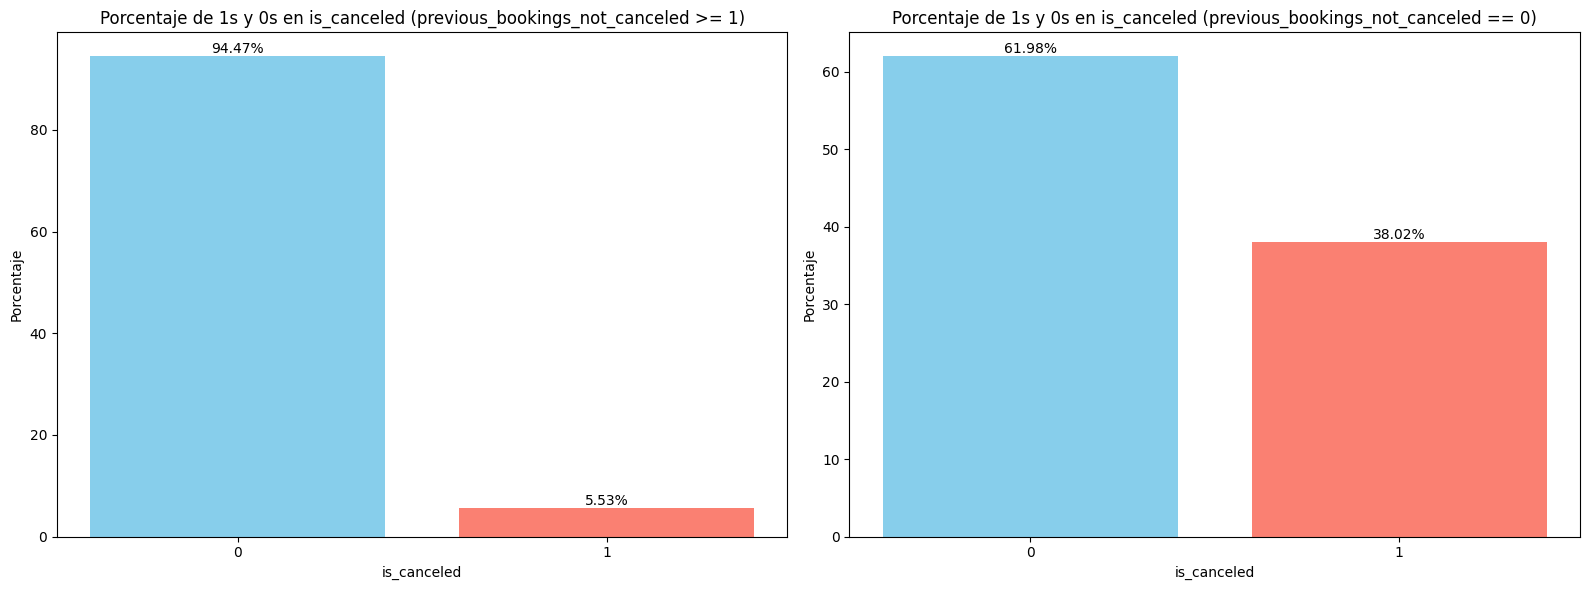

In [24]:
# Filtrar filas donde 'previous_bookings_not_canceled >= 1'
filtered_data_1 = data[data['previous_bookings_not_canceled'] >= 1]

# Filtrar filas donde 'previous_bookings_not_canceled == 0'
filtered_data_2 = data[data['previous_bookings_not_canceled'] == 0]

# Calcular el porcentaje de cada categoría para 'previous_bookings_not_canceled >= 1'
cancel_counts_1 = filtered_data_1['is_canceled'].value_counts(normalize=True) * 100

# Calcular el porcentaje de cada categoría para 'previous_bookings_not_canceled == 0'
cancel_counts_2 = filtered_data_2['is_canceled'].value_counts(normalize=True) * 100

# Crear un gráfico con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico para 'previous_bookings_not_canceled >= 1'
axes[0].bar(cancel_counts_1.index.astype(str), cancel_counts_1.values, color=['skyblue', 'salmon'])
for i, value in enumerate(cancel_counts_1):
    axes[0].text(i, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
axes[0].set_title('Porcentaje de 1s y 0s en is_canceled (previous_bookings_not_canceled >= 1)')
axes[0].set_xlabel('is_canceled')
axes[0].set_ylabel('Porcentaje')

# Gráfico para 'previous_bookings_not_canceled == 0'
axes[1].bar(cancel_counts_2.index.astype(str), cancel_counts_2.values, color=['skyblue', 'salmon'])
for i, value in enumerate(cancel_counts_2):
    axes[1].text(i, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
axes[1].set_title('Porcentaje de 1s y 0s en is_canceled (previous_bookings_not_canceled == 0)')
axes[1].set_xlabel('is_canceled')
axes[1].set_ylabel('Porcentaje')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Vamos a ver ahora el número de valores atípicos que tenemos de cada variable (los que están fuera de $[Q1-3 IQR, Q3+3IQR]$).

Revisando las variables que más tienen, parecen valores que se deben a que la mayoría de las reservas cumplen cierto patrón (por ejemplo, los adultos suelen ser 2 simplemente), y a la mínima que nos vamos un poco aparecen como outliers. Como digo, no vamos a eliminar nada, ya que no son datos incorrectos para nada, e incluso pueden ser útiles a la hora de balancear el modelo.

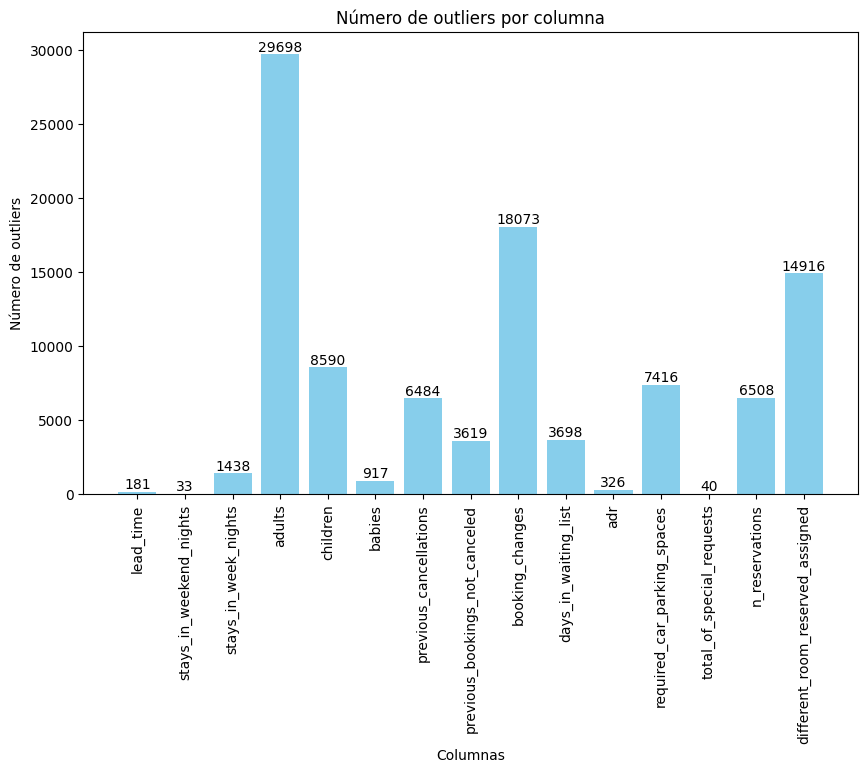

In [25]:
# Filtrar las columnas numéricas
numeric_columns = data.select_dtypes(include=['number']).columns

# Función para detectar outliers
def detect_outliers(df, columns):
    outliers = {}
    for col in columns:
        # Calcular Q1, Q3 y IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calcular los límites superior e inferior para detectar outliers
        lower_limit = Q1 - 3 * IQR
        upper_limit = Q3 + 3 * IQR
        
        # Filtrar los valores fuera de estos límites
        outliers[col] = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    
    return outliers

# Detectar los valores atípicos
outliers = detect_outliers(data, numeric_columns)

# Contar el número de outliers por columna
outlier_counts = {col: len(outliers[col]) for col in outliers}

# Graficar el número de outliers por columna
plt.figure(figsize=(10, 6))
bars = plt.bar(outlier_counts.keys(), outlier_counts.values(), color='skyblue')

# Agregar etiquetas con los valores sobre las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom', fontsize=10)

plt.title('Número de outliers por columna')
plt.xlabel('Columnas')
plt.ylabel('Número de outliers')
plt.xticks(rotation=90)  # Para que los nombres de las columnas se vean mejor
plt.show()

12º - Realizar historgramas de variables numéricas

- En primer lugar, vamos a tomar los valores sobre el número de personas que hay en una reserva (adults, children y babies): Podemos ver claramente como la mayoría de reservas que tenemos tienen 2 adultos y 0 niños. Esto nos puede hacer pensar que la mayoría de las reservas son de parejas. Quizás de cara a realizar una campaña de márketing, podríamos enfocarnos en este tipo de público.

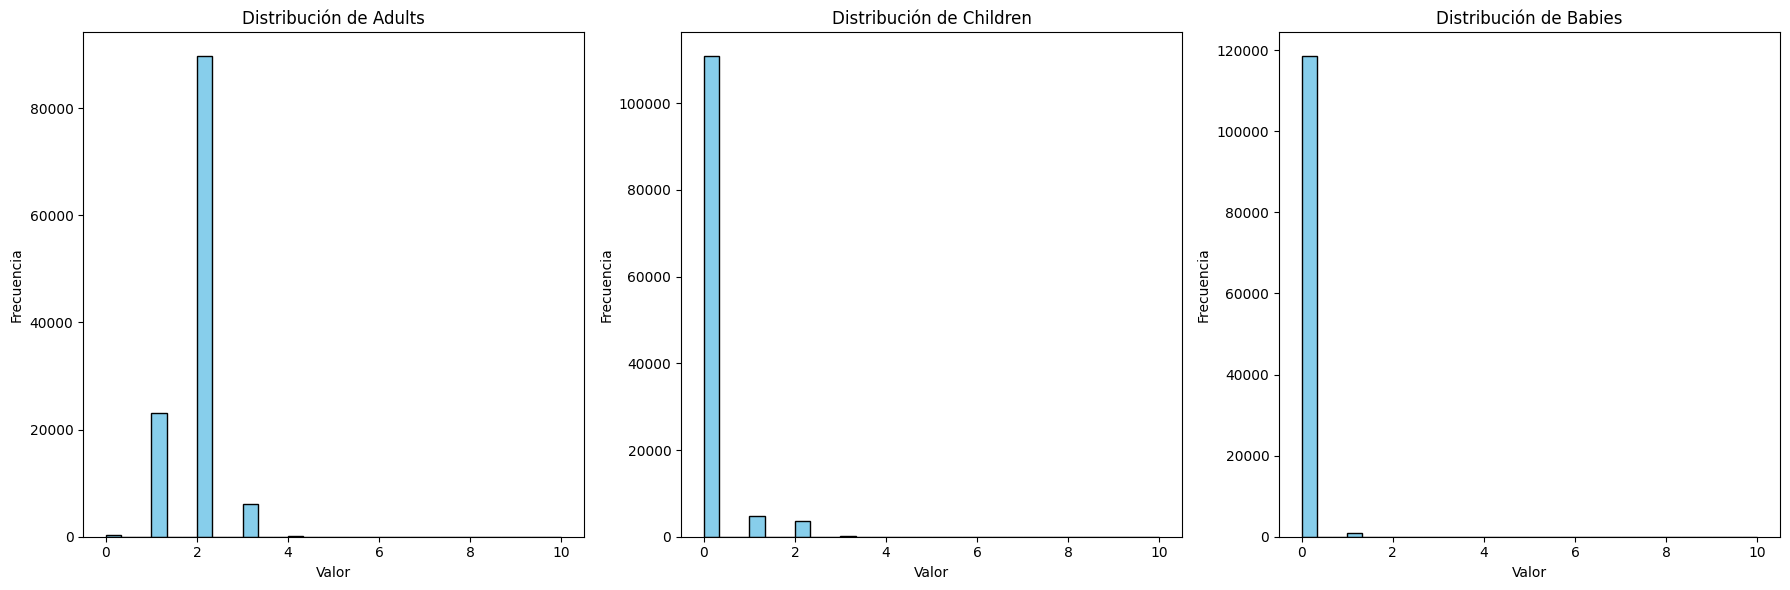

In [26]:
# Filtrar las columnas de interés
columns_of_interest = ['adults', 'children', 'babies']

# Crear los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterar sobre las columnas y crear un histograma para cada una
for i, col in enumerate(columns_of_interest):
    axes[i].hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribución de {col.capitalize()}')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frecuencia')

# Ajustar el espacio entre los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

- Ahora vamos a ver el histograma de la variable ADR. Para ello, he acotado solamente las filas que tienen ADR hasta 200, ya que es dónde están la mayoría de nuestras filas, y donde tiene más sentido que se encuentren sus valores. Además, he redondeado al entero más próximo. 

Podemos ver que sigue una distribución bastante normal, excepto que en el pico donde más valores hay, que se encuentra en unos 67$ por habitación.

Y, parece un pelín preocupante el repunte que hay cercano al 0. Nos falta contexto, quizás es alguna habitación que da menos beneficio o algún tipo de oferta especial.

C:\Users\4sell\AppData\Local\Temp\ipykernel_23960\3731432212.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['adr_rounded'] = filtered_data['adr'].round()


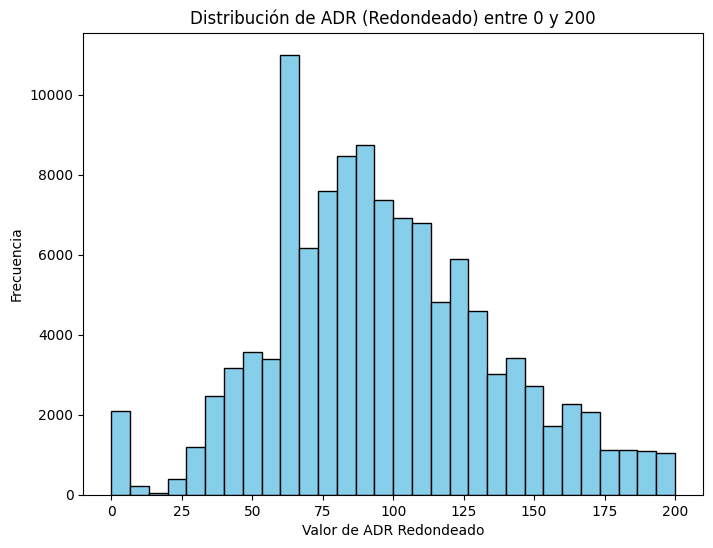

In [27]:
# Filtrar las filas donde 'adr' está entre 0 y 200
filtered_data = data[(data['adr'] >= 0) & (data['adr'] <= 200)]

# Redondear la columna 'adr' al entero más cercano
filtered_data['adr_rounded'] = filtered_data['adr'].round()

# Crear el histograma de la columna 'adr_rounded' (filtrado)
plt.figure(figsize=(8, 6))
plt.hist(filtered_data['adr_rounded'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de ADR (Redondeado) entre 0 y 200')
plt.xlabel('Valor de ADR Redondeado')
plt.ylabel('Frecuencia')
plt.show()

13º - Calcular estadísticas de variables categóricas

Vamos a coger algunas variables categóricas interesantes para realizar un análisis.
- Tenemos datos de reservas entre 2015 y 2017. El año del que más reservas disponemos es 2016.
- El mes del que más registros tenemos es el mes de Agosto.
- El hotel del que hemos extraído los datos se encuentra ubicado en Portugal. Por ello, las reservas provienen principalmente de ahí. Además, a éstos, les siguen Reino Unido y Francia.
- La mayoría de los clientes vienen con reservas que realizan sin la ayuda de una compañía. Y, la compañía que más clientes nos ha traído es la que tiene como código 40, con un total de 927 reservas.

In [28]:
# Definir las columnas de interés
selected_columns = [
    'reserved_room_type', 'arrival_date_year', 'arrival_date_month',
    'arrival_date_week_number', 'arrival_date_day_of_month', 'country', 'company'
]

# Crear un diccionario para almacenar estadísticas
categorical_stats = {}

for col in selected_columns:
    if col in data.columns:  # Asegurarse de que la columna existe en el dataframe
        # Frecuencias de las categorías
        value_counts = data[col].value_counts()
        # Almacenar estadísticas en el diccionario
        categorical_stats[col] = {
            'Número de categorías': data[col].nunique(),
            'Categorías más frecuentes': value_counts.head(3).to_dict(),
            'Valores únicos': data[col].unique()
        }

# Mostrar las estadísticas
for col, stats in categorical_stats.items():
    print(f"Estadísticas para la columna '{col}':")
    print(f"- Número de categorías: {stats['Número de categorías']}")
    print(f"- Categorías más frecuentes:")
    for category, count in stats['Categorías más frecuentes'].items():
        print(f"  {category}: {count}")
    print(f"- Valores únicos (muestra): {list(stats['Valores únicos'])[:5]}")  # Mostrar solo 5 valores únicos
    print("\n")


Estadísticas para la columna 'reserved_room_type':
- Número de categorías: 10
- Categorías más frecuentes:
  A: 85982
  D: 19199
  E: 6535
- Valores únicos (muestra): ['C', 'A', 'D', 'E', 'G']


Estadísticas para la columna 'arrival_date_year':
- Número de categorías: 3
- Categorías más frecuentes:
  2016: 56706
  2017: 40686
  2015: 21984
- Valores únicos (muestra): ['2015', '2016', '2017']


Estadísticas para la columna 'arrival_date_month':
- Número de categorías: 12
- Categorías más frecuentes:
  August: 13877
  July: 12661
  May: 11791
- Valores únicos (muestra): ['July', 'August', 'September', 'October', 'November']


Estadísticas para la columna 'arrival_date_week_number':
- Número de categorías: 53
- Categorías más frecuentes:
  33: 3580
  30: 3087
  32: 3045
- Valores únicos (muestra): ['27', '28', '29', '30', '31']


Estadísticas para la columna 'arrival_date_day_of_month':
- Número de categorías: 31
- Categorías más frecuentes:
  17: 4406
  5: 4315
  15: 4196
- Valores único

14º - Realizar diagramas de barras de variables categóricas

En primer lugar, vamos a ver cómo están nuestros datos distribuidos en el tiempo.

C:\Users\4sell\AppData\Local\Temp\ipykernel_23960\942442357.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


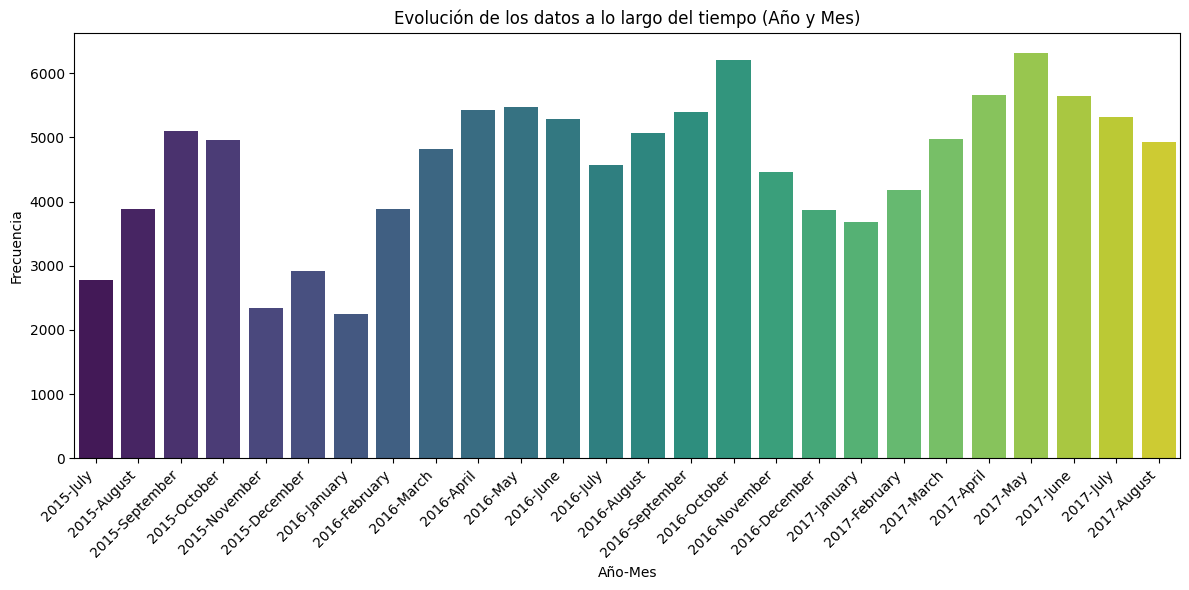

In [29]:
# Crear una lista con el orden correcto de los meses
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Crear la columna 'year_month' sin modificar los datos originales
data['year_month'] = data['arrival_date_year'].astype(str) + "-" + data['arrival_date_month']

# Contar las ocurrencias de cada combinación de año y mes
time_counts = data.groupby(['arrival_date_year', 'arrival_date_month']).size().reset_index(name='counts')

# Convertir los meses a una categoría con orden explícito
time_counts['arrival_date_month'] = pd.Categorical(
    time_counts['arrival_date_month'], categories=month_order, ordered=True
)

# Ordenar por año y mes
time_counts = time_counts.sort_values(['arrival_date_year', 'arrival_date_month'])

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(
    x=time_counts['arrival_date_year'].astype(str) + "-" + time_counts['arrival_date_month'].astype(str),
    y=time_counts['counts'],
    palette="viridis"
)

# Configurar etiquetas y título
plt.title('Evolución de los datos a lo largo del tiempo (Año y Mes)')
plt.xlabel('Año-Mes')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

En segundo lugar, vamos a ver el top 10 de las nacionalidades de nuestros clientes.

C:\Users\4sell\AppData\Local\Temp\ipykernel_23960\3902694543.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")


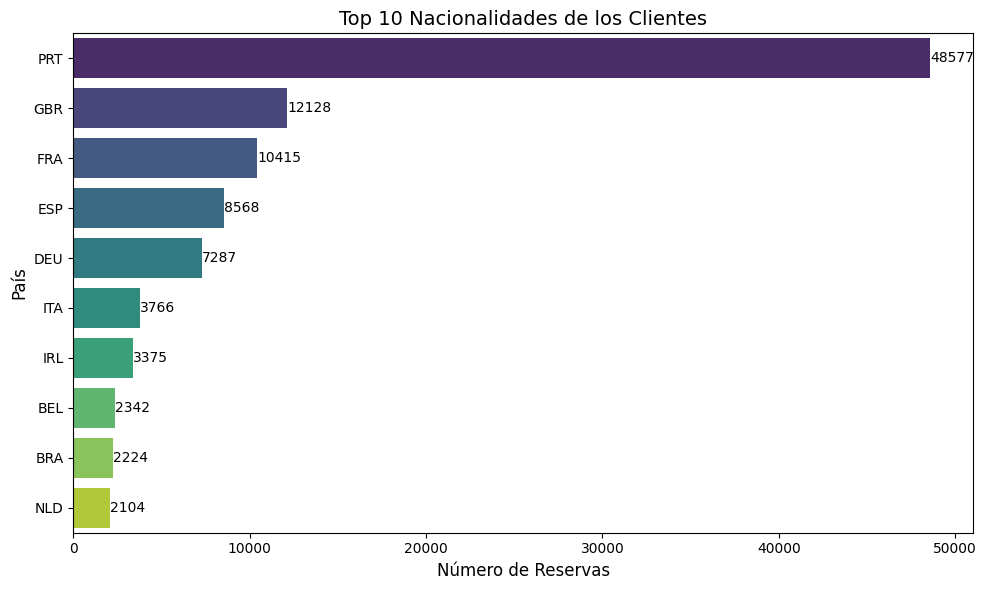

In [30]:
# Calcular las 10 nacionalidades más frecuentes
top_countries = data['country'].value_counts().head(10)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")

# Agregar los valores dentro de las barras
for index, value in enumerate(top_countries.values):
    plt.text(value, index, str(value), color='black', va='center', ha='left', fontsize=10)

# Configurar etiquetas y título
plt.title('Top 10 Nacionalidades de los Clientes', fontsize=14)
plt.xlabel('Número de Reservas', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

15º - Realizar diagramas de dispersión.

Ya hemos visto que no existe correlación entre las variables. Pero, para este punto, he tomado algunas variables que pueden ser interesantes a la hora de compararlas.
- Tiempo de antelación de una reserva y el adr: Se puede ver cómo el tiempo de antelación parece que influye un poco en el adr obtenido. Esto se debe a que, a la hora de realizar las reservas con más tiempo, el precio suele ser menor que si lo hacemos a última hora. Es bastante lógico que esto suceda así.
- Adultos y niños: En un primer momento pensé que las reservas que más adultos tenían, iban a ser las que más niños también tendrían. Sin embargo, esto no parece ser así.
- Noches entre semana y en fin de semana: Podemos ver que existe una relación bastante lineal entre estas variables. Evidentemente, cuantos más días entre semana, más días en fin de semana pasa la gente en nuestro hotel.
- Peticiones especiales y el adr: Podríamos pensar que a más peticiones, mayor adr, ya que la reserva podría ser más cara. Sin embargo, parece que estas variables no mantienen esta relación. Es posible que sea interesante fijarnos en esto de cara al futuro, y empezar a cobrar ciertos servicios que quizá ahora no estamos cobrando.

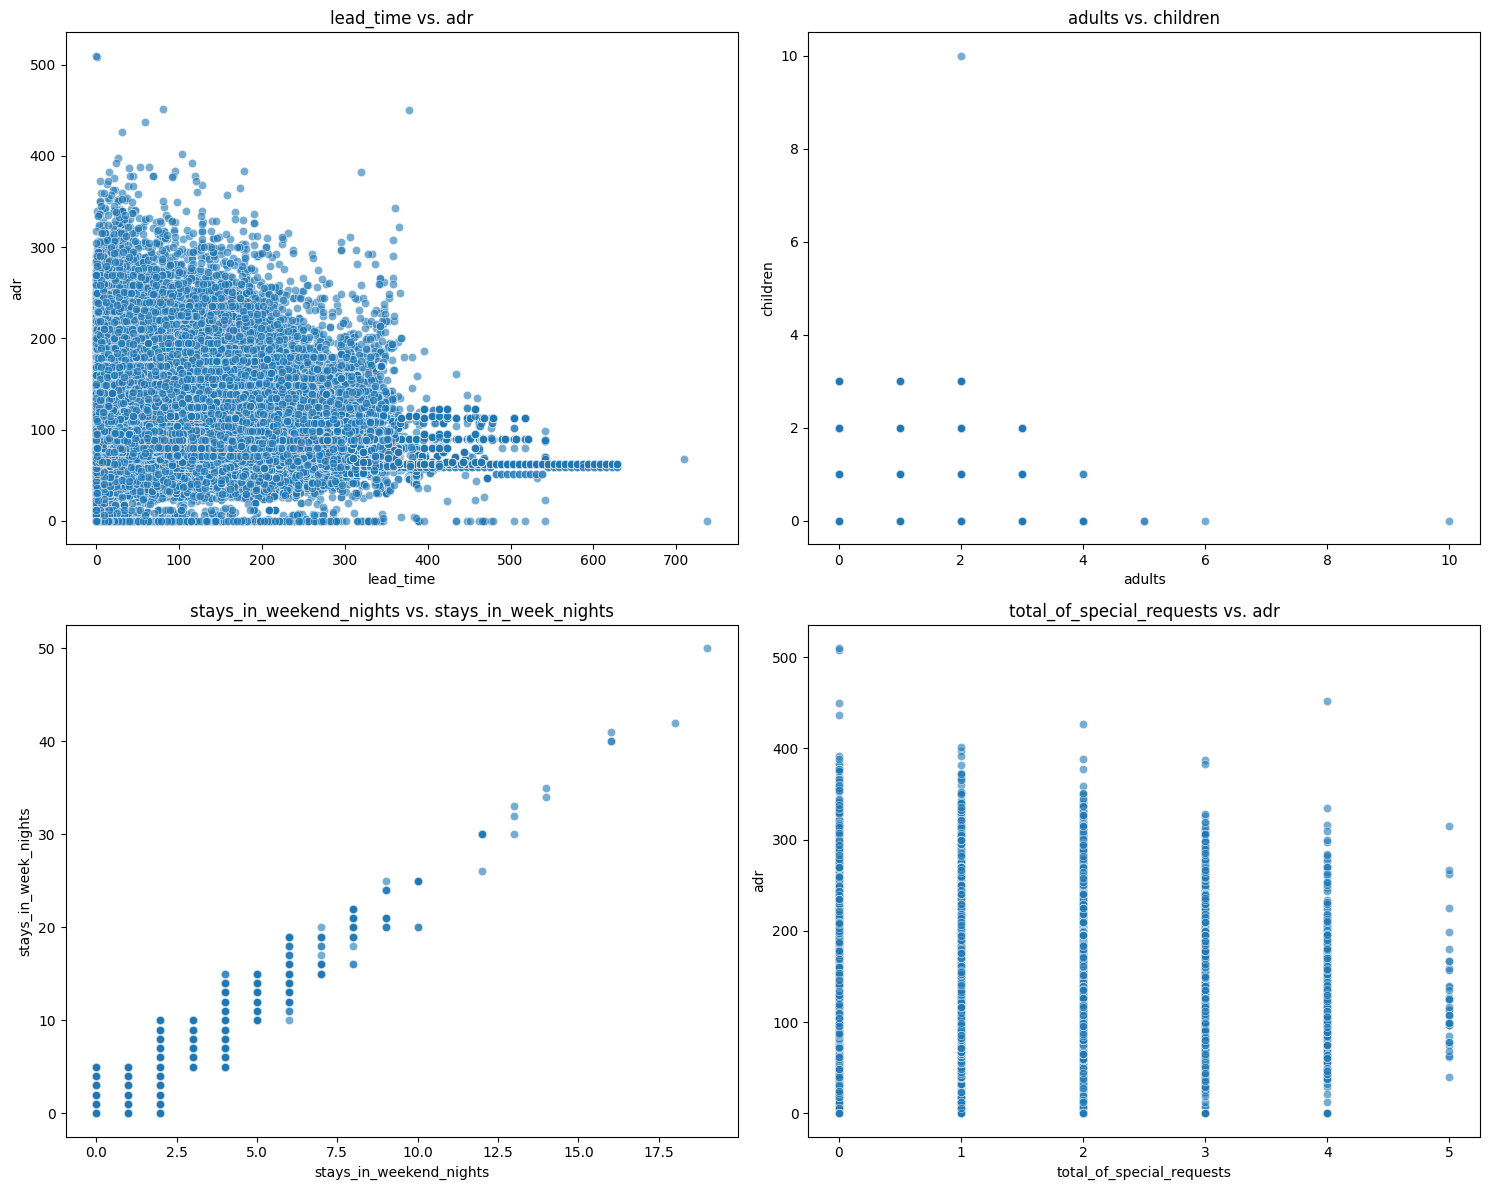

In [31]:
# Seleccionar las combinaciones de columnas para los diagramas de dispersión
scatter_plots = [
    ('lead_time', 'adr'),
    ('adults', 'children'),
    ('stays_in_weekend_nights', 'stays_in_week_nights'),
    ('total_of_special_requests', 'adr'),
]

# Crear los diagramas de dispersión
plt.figure(figsize=(15, 12))

for i, (x_col, y_col) in enumerate(scatter_plots, 1):
    plt.subplot(2, 2, i)  # Crear una cuadrícula 3x3 para los gráficos
    sns.scatterplot(data=data, x=x_col, y=y_col, alpha=0.6)  # Eliminamos palette
    plt.title(f'{x_col} vs. {y_col}')
    plt.tight_layout()

plt.show()

16º- Mapear valores de atributos categóricos


"Pivotamos" las variables categóricas. Para ello, tenemos varias opciones. En primer lugar, las variables que ya son binarias, las dejamos así. Y, las otras columnas que tienen varias categorías, las trataremos con One-Hot Encoding. He tomado unas cuantas variables categóricas, ya que pivotando todo teníamos demasiadas columnas y podía ser más difícil de interpretar el modelo.

In [32]:
# Tomamos las columnas a las que le aplicamos el One-Hot Encoding
one_hot = ['hotel', 'meal', 'market_segment','distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type', 'country', 'arrival_date_month'] #añadiendo country el número de columnas aumenta considerablemente, de momento vamos a tomarlo y después veremos si lo eliminamos del modelo o no
data = pd.get_dummies(data, columns=one_hot, drop_first=True)

data.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies',
       ...
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_May', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September'],
      dtype='object', length=248)

17º- Normalizar variables

En principio, como en la siguiente actividad vamos a utilizar RandomForest y XGboost probablemente, no sería necesario normalizar las variables. De todos modos, vamos a realizarlo y guardamos ambos dataframes, el normalizado y el sin normalizar.

In [33]:
# Inicializar el escalador MinMax
scaler = MinMaxScaler()

# Copiar el dataframe original para no modificarlo
data_normalized = data.copy()

# Aplicar MinMaxScaler a todas las columnas numéricas del nuevo dataframe
data_normalized[data_normalized.select_dtypes(include=['number']).columns] = scaler.fit_transform(
    data_normalized.select_dtypes(include=['number'])
)

18º - Eliminar variables irrelevantes.

Finalmente, vamos a eliminar columnas que no consideramos necesarias para la elaboración de los modelos.
- 'arrival_date_year': La idea es analizar a futuro si una reserva será cancelada, por lo que no parece interesante esta columna para entrenar el modelo.
- 'reservation_status_date': Tras analizar esta columna, resulta que si la reserva había sido cancelada, entonces esta fecha era previa a la fecha de la reserva; mientras que si la reserva no era cancelada, la fecha era posterior. Por ello, tras pensar en obtener alguna columna y cálculo a partir de ella, concluimos que no tiene sentido trabajar con ella, ya que alteraría el modelo.
- 'email', 'name', 'phone-number', 'company', 'credit_card': No nos interesan los datos personales de comprador. Podríamos hacer distinción por países y compañías, pero de momento vamos a trabajar sin estas variables, y nos guardamos la idea de usarlas para un futuro.
- 'assigned_room_type': Es la habitación que finalmente se asigna. Como estamos analizando las cancelaciones de las reservas, hemos decidido pivotar únicamente la columna de 'reserved_room_type', ya que normalmente cuando te asignan una habitación es porque has llegado ya al hotel.
- 'reservation_status' : Muestra el estado de la reserva. No tiene sentido esta variable ya que estamos analizando si se ha cancelado o no, y esta variable nos indica esto ya.
- 'company', 'agent': De momento vamos a eliminar estas, ya que si las pivotábamos teníamos muchas columnas. Nos lo guardamos para en un futuro añadirlo con la posibilidad de mejorar el modelo.

In [34]:
# Eliminar las columnas no necesarias
columns_to_drop = [
    'arrival_date_year',
    'reservation_status_date',    
    'email',                 
    'name',                  
    'phone-number',                 
    'company',  
    'agent',         # Las vamos a dejar fuera de momento
    'credit_card',           
    'assigned_room_type',    
    'reservation_status',  
]

# Eliminar las columnas
data = data.drop(columns=columns_to_drop)
data_normalized = data_normalized.drop(columns=columns_to_drop)

19º - Guardamos los datasets ya limpios y tratados.

In [35]:
# Guardar el dataframe original limpio
data.to_csv('hotel_booking_cleaned.csv', index=False)

# Guardar el dataframe normalizado
data_normalized.to_csv('hotel_booking_normalized_cleaned.csv', index=False)